In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import gcmpyo3

from core.amp.likelihood import logit_likelihood
from core.amp.prior.gaussian_prior import GaussianPrior
from core.amp.prior.nonseparable_gaussian_prior import NonSepGaussianPrior
from core.amp import gamp
from core.utility import KERNEL_COEFICIENTS, get_additional_noise_from_kappas, LOGISTIC_APPROX_COEF, sigmoid, build_gcm_from_activation

import simulations

%load_ext autoreload
%autoreload 2

In [4]:
d         = 200
seeds     = 1

n_over_d  = 2.0
noise_std = 0.5
noise_var = noise_std**2

activation= 'erf'
_, kappa1, kappastar = KERNEL_COEFICIENTS[activation]

In [5]:
# these values of the optimal lambda are computed with n/d = 2, noise_std = 0.5. For other values, you need to compute new values of lambda using 
inv_alpha_range = np.array([0.1, 0.14949494949494951, 0.198989898989899, 0.24848484848484848, 0.297979797979798, 0.3474747474747475, 0.396969696969697, 0.44646464646464656, 0.495959595959596, 0.5454545454545455, 0.5949494949494949, 0.6444444444444445, 0.693939393939394, 0.7434343434343434, 0.7929292929292932, 0.8424242424242424, 0.891919191919192, 0.9414141414141416, 0.990909090909091, 1.0404040404040404, 1.0898989898989901, 1.1393939393939396, 1.188888888888889, 1.2383838383838386, 1.287878787878788, 1.3373737373737375, 1.386868686868687, 1.4363636363636367, 1.4858585858585862, 1.5353535353535357, 1.5848484848484852, 1.6343434343434347, 1.6838383838383841, 1.7333333333333334, 1.782828282828283, 1.8323232323232326, 1.881818181818182, 1.9313131313131315, 1.9808080808080812, 2.0303030303030307, 2.0797979797979806, 2.1292929292929297, 2.178787878787879, 2.2282828282828286, 2.277777777777778, 2.327272727272728, 2.376767676767677, 2.4262626262626266, 2.4757575757575765, 2.525252525252526, 2.5747474747474755, 2.624242424242425, 2.6737373737373744, 2.7232323232323234, 2.772727272727274, 2.8222222222222233, 2.8717171717171723, 2.921212121212122, 2.9707070707070717, 3.020202020202021, 3.06969696969697, 3.11919191919192, 3.168686868686869, 3.2181818181818187, 3.267676767676768, 3.3171717171717177, 3.366666666666668, 3.416161616161617, 3.465656565656567, 3.5151515151515156, 3.564646464646465, 3.6141414141414154, 3.663636363636365, 3.713131313131313, 3.7626262626262625, 3.812121212121213, 3.8616161616161624, 3.911111111111112, 3.9606060606060622, 4.010101010101011, 4.05959595959596, 4.10909090909091, 4.158585858585859, 4.208080808080809, 4.257575757575759, 4.307070707070707, 4.356565656565657, 4.406060606060607, 4.455555555555557, 4.505050505050505, 4.5545454545454565, 4.604040404040404, 4.653535353535354, 4.703030303030304, 4.752525252525253, 4.802020202020202, 4.851515151515152, 4.901010101010103, 4.950505050505051, 5.0])
pb_lambda_error = np.array([0.4640618897913082, 0.2862645885235946, 0.2021526444124516, 0.1551216836580156, 0.1267539451245606, 0.108857933923834, 0.097360567877463, 0.0900079398291028, 0.0854234215794187, 0.0827395392377202, 0.0813870652136205, 0.0809863957594588, 0.0812774736430041, 0.0820794954990204, 0.0832630086094318, 0.0847368143165183, 0.0864126626205513, 0.0882788736298744, 0.0902757713351266, 0.0923719911984893, 0.0945421896070457, 0.0967677494951127, 0.0990379178756372, 0.1013357339127339, 0.1036553347781553, 0.1059866880658765, 0.1083262652069707, 0.1106645107513188, 0.1130022909345123, 0.1153323230374215, 0.1176518043933484, 0.1199581967706932, 0.122249475059807, 0.1245246250571598, 0.1267811099247595, 0.1290173976266168, 0.1312343497682894, 0.1334303239490371, 0.1356047197897472, 0.137757067453013, 0.1398879766934771, 0.1419936834942829, 0.1440787900044251, 0.1461402981071207, 0.1481780742899584, 0.1501951819259223, 0.1521863430862202, 0.1541567182073261, 0.1561047607684836, 0.1580264693385607, 0.1599315049752227, 0.1618101360824835, 0.1636675628919291, 0.1655449746591963, 0.1673595018489452, 0.1691518482823394, 0.1709221420138636, 0.1726750963377105, 0.1744050863492524, 0.1761131735570728, 0.1778023345471805, 0.1794718517361586, 0.1811218267614613, 0.1827525317914829, 0.1843642388319194, 0.1859572189554666, 0.1875317439008057, 0.1890880833923467, 0.1906264780083879, 0.1921472648405995, 0.1936506658215352, 0.1951369406743616, 0.1966063476721389, 0.1980591402920391, 0.1994955698952309, 0.2009159171722908, 0.202322562921784, 0.2037113255123195, 0.2050846981421726, 0.2064429153731939, 0.207786207775444, 0.2091148026700426, 0.2104280227906771, 0.211728041818402, 0.2130140105753244, 0.2142861406522702, 0.2155446402187772, 0.2167897147891607, 0.2180215617215637, 0.2192403869827754, 0.220445695686985, 0.2216413113153018, 0.2228208827616442, 0.2239879296597944, 0.2251458702941547, 0.2262898743909187, 0.2274224924875784, 0.2285437008814153, 0.2296536356596358, 0.2307524258283935])

index = [ i for i in range(0, len(inv_alpha_range), 5) if 4.5 >= inv_alpha_range[i] >= 0.5 ]
inv_alpha_range = inv_alpha_range[index]
pb_lambda_error = pb_lambda_error[index]
n_alpha = len(inv_alpha_range)

In [6]:
max_p        = int(n_over_d * d * inv_alpha_range[-1])
F_global     = np.random.normal(0.0, 1.0, size=(max_p, d)) / np.sqrt(d)

In [8]:
v_array, q_array, m_array = np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha))

for s in range(seeds):
    try:
        m_list, q_list, v_list = simulations.eb_trial(d, n_over_d, inv_alpha_range, pb_lambda_error, kappa1, kappastar, noise_std, F_global)
        q_array[s] = q_list
        m_array[s] = m_list
        v_array[s] = v_list
        
    except Exception as e:
        print(e)
        q_array[s] = q_array[s-1]
        m_array[s] = m_array[s-1]
        v_array[s] = v_array[s-1]

16it [01:01,  3.83s/it]


In [9]:
m_list = np.mean(m_array, axis = 0)
q_list = np.mean(q_array, axis = 0)
v_list = np.mean(v_array, axis = 0)

In [10]:
# Theoretical values for the overlaps 

qs_for_erm_error = []
ms_for_erm_error = []
vs_for_erm_error = []

for inv_alpha, lambda_ in tqdm(zip(inv_alpha_range, pb_lambda_error)):
    alpha = 1. / inv_alpha
    gamma = n_over_d / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.pseudo_bayes_state_evolution_gcm(alpha, 1.0, noise_var, gamma, kappa1, kappastar, lambda_, 1.0, "logit", 1e-6, True, True, False)
    qs_for_erm_error.append(q)
    ms_for_erm_error.append(m)
    vs_for_erm_error.append(v)

16it [00:02,  5.56it/s]


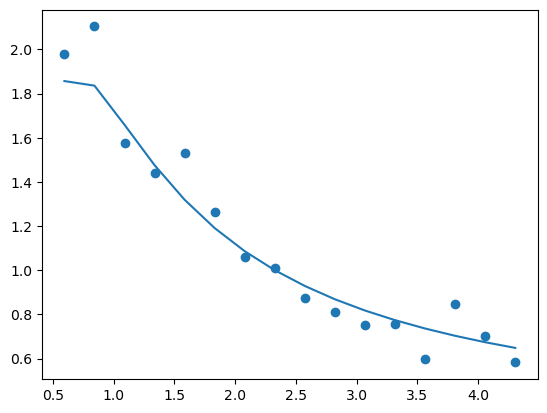

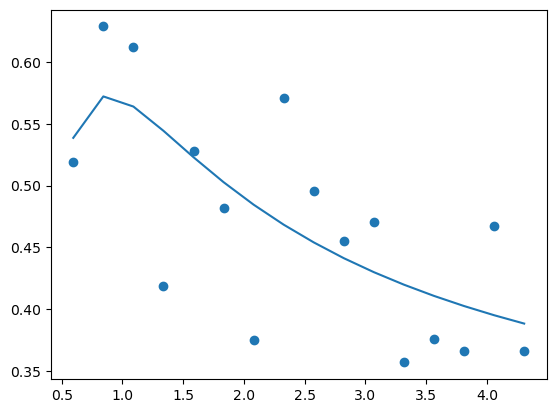

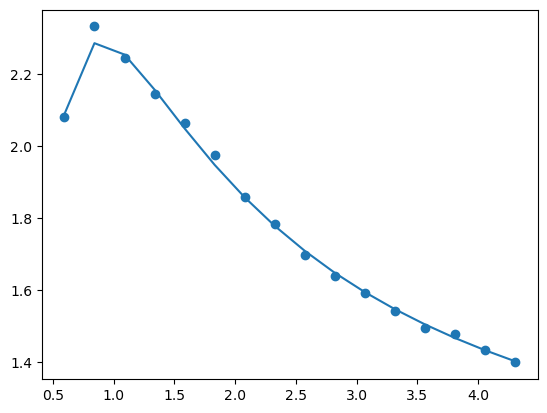

In [11]:
# Comparison of state evolution and empirical values

plt.scatter(inv_alpha_range, q_list)
plt.plot(inv_alpha_range, qs_for_erm_error)
plt.show()

plt.scatter(inv_alpha_range, m_list)
plt.plot(inv_alpha_range, ms_for_erm_error)
plt.show()

plt.scatter(inv_alpha_range, v_list)
plt.plot(inv_alpha_range, vs_for_erm_error)
plt.show()

In [12]:
print('Experimental values of m : ')
print(list(m_list))
print('Experimental values of q : ')
print(list(q_list))
print('Experimental values of v : ')
print(list(v_list))

[0.5949494949494949, 0.8424242424242424, 1.0898989898989901, 1.3373737373737375, 1.5848484848484852, 1.8323232323232326, 2.0797979797979806, 2.327272727272728, 2.5747474747474755, 2.8222222222222233, 3.06969696969697, 3.3171717171717177, 3.564646464646465, 3.812121212121213, 4.05959595959596, 4.307070707070707]
[0.538729232370507, 0.5723015122034488, 0.5640957946048198, 0.5444516699648189, 0.5230391274295326, 0.5028313074663092, 0.48459812106143685, 0.46839318696969806, 0.4540365963723615, 0.44124007036597773, 0.4299109982978012, 0.41978262984201237, 0.4106852219695664, 0.4024758693112234, 0.3950327133680981, 0.3882608823376444]
[1.8564517982842597, 1.8358076201264142, 1.6585528613723644, 1.4756150783941002, 1.319103467692311, 1.1908127325235343, 1.0861473693266082, 1.000165699635917, 0.9287598284946226, 0.8685466552181768, 0.8176593143244203, 0.7740082854568466, 0.7362124203764887, 0.7032076369112891, 0.6741575260133575, 0.6484273693342791]
[2.089106989680109, 2.28631266333572, 2.2546